In [1]:
# Replace part of the OUTPUT_PATH to create a new folder 
# for the detection results

OLD_prefix = "LoanApplications_Offline"
NEW_prefix = "LoanApplications_Offline__DETECTION"

In [95]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# My packages
from source import parse_mxml as pm
from source import log_representation as lr
from source import plots as plts
from source import drift_detection as dd
from source import drift_localization as dl
from source import offline_streaming_clustering as off_sc

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed, parallel_backend

import random
random.seed(42)

import os
import glob

import gc
gc.enable()

from scipy.spatial import distance
from sklearn.base import clone as sk_clone 

from copy import deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

def if_any(string, lista):
    # If the string contains any of the values
    # from the list 'lista'
    for l in lista:
        if l in string:
            return True
    return False

In [97]:
# List log files
logs = insensitive_glob(r"../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/*/*k.MXML")
logs = [x.replace('\\', '/') for x in logs if "2.5" not in x]
# logs = [x for x in logs if "2.5" not in x]

In [77]:
# reference objects and map them to strings in dict 
# used in further methods
objects = {
    "model": {
        "kmeans__k=6": KMeans(n_clusters=6, random_state=42),
        "kmeans__k=3": KMeans(n_clusters=3, random_state=42),
        "kmeans__k=2": KMeans(n_clusters=2, random_state=42),
        "DBSCAN__eps=05ms=5": DBSCAN(eps=0.5, min_samples=5, metric='euclidean'),
        "DBSCAN__eps=1ms=4": DBSCAN(eps=1, min_samples=4, metric='euclidean'),
        "DBSCAN__eps=2ms=3": DBSCAN(eps=2, min_samples=3, metric='euclidean'),
        "HDBSCAN__noparams": hdbscan.HDBSCAN()
    },
    
    "representation": {
        "activity_binary": lambda x: lr.get_binary_representation(lr.get_traces_as_tokens(x)),
        "activity_frequency": lambda x: lr.get_frequency_representation(lr.get_traces_as_tokens(x)),
        "transitions_binary": lambda x: lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)),
        "transitions_frequency": lambda x: lr.get_frequency_transitions_representation(lr.get_traces_as_tokens(x)),
        "activity_transitions_frequency": lambda x: pd.concat([lr.get_frequency_transitions_representation(lr.get_traces_as_tokens(x)), lr.get_frequency_representation(lr.get_traces_as_tokens(x))],axis=1),
        "activity_transitions_binary": lambda x: pd.concat([lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)), lr.get_binary_representation(lr.get_traces_as_tokens(x))],axis=1)
    }
}

In [47]:
# change patterns and they supported representations
activity_binary = ["cb", "cf", "cm", "fr", "pm", "re", "rp"]
activity_frequency = activity_binary + ["cp", "lp"]
transitions_binary = activity_frequency + ["cd", "pl", "sw"]
transitions_frequency = transitions_binary
activity_transitions_frequency = transitions_binary
activity_transitions_binary = transitions_binary

### Pipeline Offline Clustering

In [6]:
OUTPUT_PATH = "LoanApplications_Offline/"

In [7]:
def read_file_and_run_clustering_pipeline(args, return_result=False):
    """
    Read an event log file, represent it into a feature vector space and
    run the trace clustering method over windows. This method outputs results
    as gzip csv files into the "OUTPUT_PATH" folder, or return the result 
    as DataFrame when return_result = True.
    
    Parameters:
    -----------
        args (dict): Dictionary with the parameters and the log_file path
            requiring the following keys:
                example = {
                    'log': <PATH TO LOG_FILE>,
                    'representation': <KEY TO REPRESENTATIONS IN 'objects'>,
                    'parameters': [{
                        'model': <KEY TO MODEL IN 'objects'>, 
                        'sliding_window': <WHETHER TO USE SLIDING WINDOW>,
                        'window_size': <SIZE OF TRACE WINDOW TO USE>,
                        'sliding_step': <STEP OF SLIDING WINDOW>
                    }
        return_result (bool): Whether to return the result as DataFrame
            
    """
    
    # Treat file name to structure size and log type
    split = args["log"].split("/")
    
    # Parse change pattern name
    cd_name = split[-2]
    log_name = split[-1][:-5]

    # Parse size of the event_log
    log_size = log_name.replace(cd_name, "").replace("new_", "")
    log_size = int(float(log_size.replace("k", "")) * 1000)
    
    # Set up true drifts indexes
    y_true = [x for x in range(int(log_size/10), log_size, int(log_size/10))]
    
    try:
        # Read log and apply trace representation technique
        log_read = pm.all_prep(open(args["log"]))
        df = objects["representation"][args["representation"]](
            log_read
        )
        
        col_names = df.columns
        
        for p in args["parameters"]:
            # String to identify results when exporting files
            tipo_mudanca = cd_name.replace("new_", "")
            
            cached_info = "_".join([
                tipo_mudanca,
                str(log_size),
                p["model"],
                args["representation"],
                str(p["window_size"]),
                str(p["sliding_window"])
            ])
            
            print(cached_info)
            
            # If already exists, return if needed
            file_to_export = OUTPUT_PATH + tipo_mudanca + '/' + cached_info + '.pickle.gzip'
            if os.path.exists(file_to_export):
                if return_result:
                    r_ = pd.read_pickle(
                        file_to_export,
                        compression='gzip'
                    )
                    return r_
                else:
                    continue
            
            # If file does not exists, run trace clustering step and export file
            all_metrics = off_sc.run_offline_clustering_window(
                sk_clone(objects["model"][p["model"]]),
                p["window_size"],
                df,
                p["sliding_window"],
                sliding_step=p['sliding_step']
            )
            
            if return_result:
                return all_metrics
            else:
                try:
                    os.makedirs(OUTPUT_PATH + tipo_mudanca + '/')
                except:
                    pass
                all_metrics.to_pickle(file_to_export, compression="gzip")

            gc.collect()
    except Exception as e:
        pass
#         raise e

#### Run pipeline for specific case(s)

In [8]:
# all_metrics = read_file_and_run_clustering_pipeline({
#     'log': '../process_mining_datasets\\fr\\fr5k.mxml',
#     'representation': 'binary',
#     'parameters': [{
#         'model': 'kmeans__k=3', 
#         'sliding_window': False,
#         'window_size': 125,
#         'sliding_step': 1
#     }]
# }, return_result=True)

In [9]:
# all_metrics.head(2)

### Run Experiments with several parameters combinations

In [102]:
# Trace clustering parameters
grid_parameters = list(ParameterGrid({
    "sliding_window": [False],    
    "window_size": [75, 100, 125, 150, 175, 200],
    'sliding_step': [1],
    "model": [
        'kmeans__k=6',
        'kmeans__k=3',
        'kmeans__k=2',
        "DBSCAN__eps=05ms=5",
        "DBSCAN__eps=1ms=4",
        "DBSCAN__eps=2ms=3",
        "HDBSCAN__noparams"
    ] 
}))

# Trace vector representations
grid_logs = list(ParameterGrid([
#     {
#         "log": [x for x in logs if if_any(x, transitions_support)],
#         "representation": list(objects['representation'].keys())
#     }
    {
        "log": [x for x in logs if if_any(x, activity_binary)],
        "representation": ["activity_binary"]
    },
    {
        "log": [x for x in logs if if_any(x, activity_frequency)],
        "representation": ["activity_frequency"]
    },
    {
        "log": [x for x in logs if if_any(x, transitions_binary)],
        "representation": ["transitions_binary"]
    },
    {
        "log": [x for x in logs if if_any(x, transitions_frequency)],
        "representation": ["transitions_frequency"]
    },
    {
        "log": [x for x in logs if if_any(x, activity_transitions_frequency)],
        "representation": ["activity_transitions_frequency"]
    },
    {
        "log": [x for x in logs if if_any(x, activity_transitions_binary)],
        "representation": ["activity_transitions_binary"]
    }
]))

# Combining all parameters
combs = []
for x in grid_logs:
    dic = x.copy()
    dic['parameters'] = grid_parameters
    
    combs.append(dic)

len(combs), len(grid_parameters), len(combs) * len(grid_parameters) 

(192, 42, 8064)

#### Run parallely

In [11]:
final_resp = Parallel(n_jobs=3)(
    delayed(read_file_and_run_clustering_pipeline)(comb) for comb in tqdm_notebook(combs)
)

### Detection Pipeline

In [12]:
# Drift detection parameters
drift_config = list(ParameterGrid([
    {
        "rolling_window": [3, 4, 5],
        "std_tolerance": [1.25, 1.5, 1.75, 2],
        'min_tol': [0.01, 0.007, 0.005, 0.003] 
    }
]))

In [ ]:
# List all files obtained after the trace clustering pipeline

clusterizacoes = glob.glob(OUTPUT_PATH + "*/*.pickle.gzip")

In [14]:
# Combinations to run

combs_deteccao = []
for log in clusterizacoes:
    combs_deteccao.append({
        'input': log,
        'combinations': drift_config
    })

In [23]:
def drift_detect_pipeline(args, return_results=False):
    """
        Runs the drift detection method based on the output from the trace
        clustering pipeline for different combination of parameters and every
        feature from tracking the trace clustering evolution. The
        outputs are into a new folder named by the NEW_prefix variable in 
        gzip csv files.
        
        Parameters:
        -----------
            args (dict): Dictionary with the parameters and the log_file path
                requiring the following keys:
                    example = {
                    }
    """
    # Read file
    all_metrics = pd.read_pickle(args["input"], compression='gzip')
    
    # Parse information from file name
    path_file = args["input"].replace(".pickle.gzip", "").split('\\')
    args.update({
        "tipo_mudanca": path_file[-1].split('_')[0],
        "log_size": int(path_file[-1].split('_')[1]),
        "model": "_".join(path_file[-1].split('_')[2:5]),
        "representation": "_".join(path_file[-1].split('_')[5:-2]),
        "window_size": path_file[-1].split('_')[-2],
        "sliding_window": path_file[-1].split('_')[-1]
    })
    
    # Run detection for every combination of parameter    
    for combination in args['combinations']:
        c = deepcopy(combination)
        c.update({
            'input': args['input'],
            'tipo_mudanca': args['tipo_mudanca'],
            'log_size': args['log_size'],
            'model': args['model'],
            'representation': args['representation'],
            'window_size': args['window_size'],
            'sliding_window': args['sliding_window']
        })
        
        if return_results:
            return __drift_detect_pipeline(
                all_metrics, c, return_results
            )
        else:
            __drift_detect_pipeline(
                all_metrics, c, return_results
            )
    

def __drift_detect_pipeline(all_metrics, args, return_results=False):     
    base_name = args["input"].replace(".pickle.gzip", "")
    base_name = base_name.replace(OLD_prefix, NEW_prefix)
    
    # Create string with parameters to identify file
    to_string = [
        str(args["rolling_window"]),
        str(args["std_tolerance"]).replace(".", "-"), 
        str(args["min_tol"]).replace(".", "-")
    ]
    
    try:
        os.makedirs(base_name)
    except:
        pass
    
    final_name = base_name.replace("\\", "/") + "/" + "_".join(to_string) + ".pickle.gzip"
    
    if os.path.isfile(final_name):
        if return_results:
            return pd.read_pickle(final_name, compression='gzip')
        else:
            print("Already exists")
            return
    
    y_true = [x for x in range(int(args['log_size']/10), args['log_size'], int(args['log_size']/10))]
    
    # Runs the drift detection for every feature
    results = []
    for col in all_metrics.select_dtypes(include=np.number).columns:
        if (col not in ["k"] and not col.startswith("diff") ) or col in ["diff_centroids"]:
            r = deepcopy(args)
            r["measure"] = col

            detected_drifts, extra = dd.detect_concept_drift(
                all_metrics, 
                col,
                args["rolling_window"],
                args["std_tolerance"],
                args["min_tol"]
            )    
    
            # Calculate classification metrics
            metrics_results = dd.get_metrics(
                detected_drifts,
                y_true,
                int(args["window_size"])
            )

            r.update(args)
            r.update(metrics_results)

            results.append(r)

            gc.collect()
    
    # Export as file
    pd.DataFrame(results).to_pickle(
        final_name,
        compression="gzip"
    )
    
    if return_results:
        return pd.DataFrame(results)
    
    # print(col, len(results))

In [17]:
# detection_results = drift_detect_pipeline({
#     'input': '../LoanApplications_Offline\\cb\\cb_10000_kmeans__k=2_binary_100_False.pickle.gzip',
#     'combinations': [{
#        'min_tol': 0.01,
#        'rolling_window': 3,
#        'std_tolerance': 1.25
#     }, {
#        'min_tol': 0.02,
#        'rolling_window': 3,
#        'std_tolerance': 1.25
#     }]
# }, return_results=True)

In [18]:
# detection_results.sort_values('F1', ascending=False).head(2)

#### Run parallely

In [24]:
final_resp = Parallel(n_jobs=3)(
    delayed(drift_detect_pipeline)(comb_d) for comb_d in tqdm_notebook(combs_deteccao)
)

## See Results

In [4]:
models = ["DBSCAN__eps=05_ms=5", "DBSCAN__eps=1_ms=4", "DBSCAN__eps=2_ms=3"]

In [11]:
for model in models:
    print(model)
    # List all files obtained after the trace clustering pipeline
    # deteccoes = glob.glob(NEW_prefix + "/pl/*/*.pickle.gzip")
    # deteccoes = glob.glob(NEW_prefix + "/*/*/*.pickle.gzip")
    deteccoes = glob.glob(NEW_prefix + "/*/*"+model+"*/*.pickle.gzip")
    print(len(deteccoes))

    # Read all results
    all_results = pd.DataFrame()
    for log in tqdm_notebook(deteccoes):
        # Read file
        temp = pd.read_pickle(log, compression='gzip')
        # Append results
        all_results = all_results.append([temp])

    print(all_results.shape)

    # Export as file
    all_results_HDBSCAN.to_pickle(
        'all_results_'+model,
        compression="gzip"
    )

DBSCAN__eps=05_ms=5
40032



(680544, 19)
DBSCAN__eps=1_ms=4
38016



(645984, 19)
DBSCAN__eps=2_ms=3
37728



(641376, 19)


In [15]:
# Import as file
all_results = pd.read_pickle('all_results_HDBSCAN', compression='gzip')
print(all_results.shape)
all_results.head()

(641232, 19)


,min_tol,rolling_window,std_tolerance,input,tipo_mudanca,log_size,model,representation,window_size,sliding_window,measure,Precision,Recall,F1,Delay,Correct_Predictions,Support,Drifts_Found,Resp
0,0.003,3,1.25,LoanApplications_Offline\cb\cb_5000_HDBSCAN__n...,cb,5000,HDBSCAN__noparams,activity_binary,100,False,Silhouette,0.800000,0.888889,0.842105,62.500000,"[1, 1, 1, 1, 1, 1, 1, 0, 1]",8,"[600, 1100, 1500, 2000, 2600, 3100, 3500, 3900...","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."
1,0.003,3,1.25,LoanApplications_Offline\cb\cb_5000_HDBSCAN__n...,cb,5000,HDBSCAN__noparams,activity_binary,100,False,DBi,0.900000,1.000000,0.947368,33.333333,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,"[500, 1000, 1500, 2000, 2600, 3100, 3500, 4000...","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."
2,0.003,3,1.25,LoanApplications_Offline\cb\cb_5000_HDBSCAN__n...,cb,5000,HDBSCAN__noparams,activity_binary,100,False,avg_dist_between_centroids,0.727273,0.888889,0.800000,75.000000,"[1, 1, 1, 0, 1, 1, 1, 1, 1]",8,"[600, 1000, 1500, 1900, 2300, 2700, 3100, 3600...","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."
3,0.003,3,1.25,LoanApplications_Offline\cb\cb_5000_HDBSCAN__n...,cb,5000,HDBSCAN__noparams,activity_binary,100,False,std_dist_between_centroids,0.500000,0.555556,0.526316,80.000000,"[1, 1, 0, 0, 0, 0, 1, 1, 1]",5,"[500, 1000, 1400, 1800, 2300, 2900, 3600, 4200...","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."
4,0.003,3,1.25,LoanApplications_Offline\cb\cb_5000_HDBSCAN__n...,cb,5000,HDBSCAN__noparams,activity_binary,100,False,avg_radius,0.333333,0.333333,0.333333,66.666667,"[1, 0, 0, 1, 1, 0, 0, 0, 0]",3,"[500, 900, 1400, 2000, 2700, 3400, 3900, 4400,...","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."


In [56]:
# Group results by all params and get the mean F1 and Delay among all scenarios
# In other words, what combination of params got the best results in all scenarios

params = ["min_tol", "rolling_window", "std_tolerance", "window_size", "measure", "representation"]
scenarios = ["tipo_mudanca", "log_size"]
validation_metrics = ["F1","Delay"]#,"Support","Precision","Recall"]

all_results_grouped = all_results.groupby(params)[validation_metrics].agg(['mean','std','count'])
all_results_grouped.columns = all_results_grouped.columns.map('_'.join)
all_results_grouped = all_results_grouped[all_results_grouped['F1_count']>=len(activity_binary)*3]
all_results_grouped.sort_values(["F1_mean","Delay_mean"], ascending=[False,True], inplace=True)
all_results_grouped.head(30)

,,,,,,F1_mean,F1_std,F1_count,Delay_mean,Delay_std,Delay_count
min_tol,rolling_window,std_tolerance,window_size,measure,representation,,,,,,
0.003,3,2.00,125,std_diff_centroids,transitions_binary,0.767611,0.205946,21,124.163832,32.806999,21
0.005,3,2.00,125,std_diff_centroids,transitions_binary,0.767611,0.205946,21,124.163832,32.806999,21
0.007,3,2.00,125,std_diff_centroids,transitions_binary,0.767611,0.205946,21,124.163832,32.806999,21
0.010,3,2.00,125,std_diff_centroids,transitions_binary,0.767611,0.205946,21,124.163832,32.806999,21
0.003,3,2.00,125,diff_centroids,activity_transitions_binary,0.766621,0.208225,21,126.962868,40.835340,21
0.005,3,2.00,125,diff_centroids,activity_transitions_binary,0.766621,0.208225,21,126.962868,40.835340,21
0.007,3,2.00,125,diff_centroids,activity_transitions_binary,0.766621,0.208225,21,126.962868,40.835340,21
0.010,3,2.00,125,diff_centroids,activity_transitions_binary,0.766621,0.208225,21,126.962868,40.835340,21
0.003,3,1.75,125,diff_centroids,activity_transitions_binary,0.762582,0.196846,21,118.480726,35.524378,21


In [57]:
best_result = pd.merge(left=all_results, right=all_results_grouped.head(1), how='inner', on=params)
best_result

,min_tol,rolling_window,std_tolerance,input,tipo_mudanca,log_size,model,representation,window_size,sliding_window,...,Correct_Predictions,Support,Drifts_Found,Resp,F1_mean,F1_std,F1_count,Delay_mean,Delay_std,Delay_count
0,0.003,3,2.0,LoanApplications_Offline\cb\cb_5000_HDBSCAN__n...,cb,5000,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 1, 1, 0, 1, 1, 0, 0, 1]",6,"[625, 1250, 1750, 2500, 3125, 3875, 4500]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000...",0.767611,0.205946,21,124.163832,32.806999,21
1,0.003,3,2.0,LoanApplications_Offline\cb\cb_7500_HDBSCAN__n...,cb,7500,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 0, 0, 1, 1, 0, 0, 1, 1]",5,"[1000, 2125, 3250, 3875, 4375, 5000, 5625, 612...","[750, 1500, 2250, 3000, 3750, 4500, 5250, 6000...",0.767611,0.205946,21,124.163832,32.806999,21
2,0.003,3,2.0,LoanApplications_Offline\cd\cd_5000_HDBSCAN__n...,cd,5000,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 1, 1, 0, 1, 1, 1, 0, 1]",7,"[625, 1250, 1750, 2500, 3125, 3750, 4500]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000...",0.767611,0.205946,21,124.163832,32.806999,21
3,0.003,3,2.0,LoanApplications_Offline\cf\cf_5000_HDBSCAN__n...,cf,5000,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,"[625, 1125, 1625, 2125, 2625, 3125, 3625, 4125...","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000...",0.767611,0.205946,21,124.163832,32.806999,21
4,0.003,3,2.0,LoanApplications_Offline\cf\cf_7500_HDBSCAN__n...,cf,7500,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 1, 0, 1, 1, 1, 1, 1, 1]",8,"[875, 1625, 2125, 3000, 3875, 4625, 5250, 6125...","[750, 1500, 2250, 3000, 3750, 4500, 5250, 6000...",0.767611,0.205946,21,124.163832,32.806999,21
5,0.003,3,2.0,LoanApplications_Offline\cm\cm_5000_HDBSCAN__n...,cm,5000,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,"[625, 1125, 1625, 2125, 2625, 3125, 3625, 4125...","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000...",0.767611,0.205946,21,124.163832,32.806999,21
6,0.003,3,2.0,LoanApplications_Offline\cm\cm_7500_HDBSCAN__n...,cm,7500,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 1, 0, 1, 1, 1, 1, 0, 0]",6,"[875, 1500, 2125, 2625, 3125, 3875, 4625, 5250...","[750, 1500, 2250, 3000, 3750, 4500, 5250, 6000...",0.767611,0.205946,21,124.163832,32.806999,21
7,0.003,3,2.0,LoanApplications_Offline\cp\cp_5000_HDBSCAN__n...,cp,5000,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,"[625, 1125, 1625, 2125, 2625, 3125, 3625, 4125...","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000...",0.767611,0.205946,21,124.163832,32.806999,21
8,0.003,3,2.0,LoanApplications_Offline\cp\cp_7500_HDBSCAN__n...,cp,7500,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 1, 0, 1, 1, 1, 1, 1, 1]",8,"[875, 1625, 2125, 3125, 3875, 4625, 5250, 6125...","[750, 1500, 2250, 3000, 3750, 4500, 5250, 6000...",0.767611,0.205946,21,124.163832,32.806999,21
9,0.003,3,2.0,LoanApplications_Offline\fr\fr_5000_HDBSCAN__n...,fr,5000,HDBSCAN__noparams,transitions_binary,125,False,...,"[1, 0, 0, 1, 0, 1, 1, 0, 0]",4,"[625, 1375, 2125, 3125, 3750, 4375]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000...",0.767611,0.205946,21,124.163832,32.806999,21


In [58]:
best_result.pivot(index='tipo_mudanca', columns='log_size', values='F1')

log_size,5000,7500,10000
tipo_mudanca,,,
cb,0.750000,0.555556,NaN
cd,0.875000,NaN,NaN
cf,1.000000,0.888889,NaN
cm,1.000000,0.600000,NaN
cp,1.000000,0.888889,NaN
fr,0.533333,0.625000,NaN
lp,0.454545,NaN,NaN
pl,0.941176,0.777778,NaN
pm,1.000000,0.631579,NaN


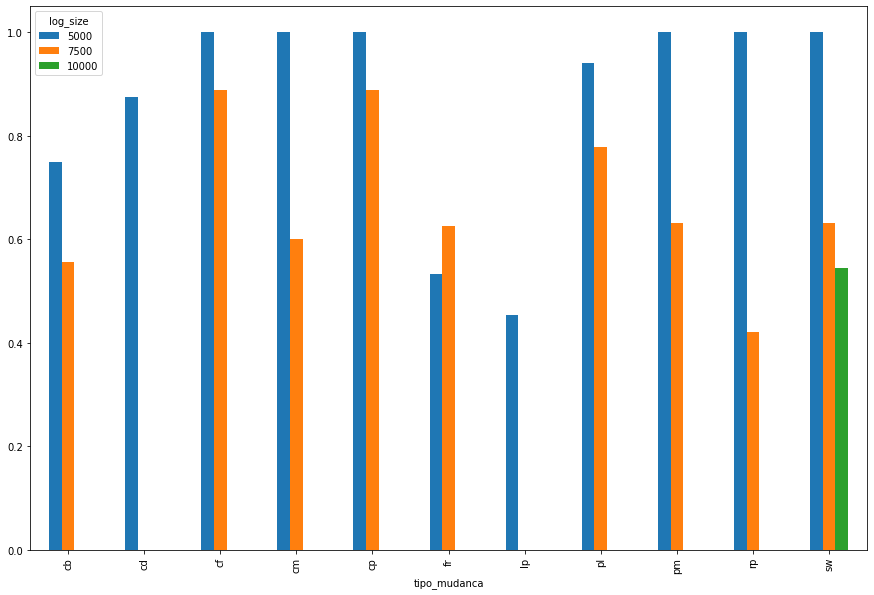

In [59]:
best_result.pivot(index='tipo_mudanca', columns='log_size', values='F1').plot(kind='bar', figsize=(15,10))

In [65]:
best_result.iloc[0,]

min_tol                                                            0.003
rolling_window                                                         3
std_tolerance                                                          2
input                  LoanApplications_Offline\cb\cb_5000_HDBSCAN__n...
tipo_mudanca                                                          cb
log_size                                                            5000
model                                                  HDBSCAN__noparams
representation                                        transitions_binary
window_size                                                          125
sliding_window                                                     False
measure                                               std_diff_centroids
Precision                                                       0.857143
Recall                                                          0.666667
F1                                                 

In [104]:
{'log': '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cb/cb10k.mxml',
  'representation': 'activity_binary',
  'parameters': [{'model': 'kmeans__k=6',
    'sliding_step': 1,
    'sliding_window': False,
    'window_size': 75},

SyntaxError: unexpected EOF while parsing (<ipython-input-104-6d60c1c87cef>, line 6)

In [100]:
logs

['../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cb/cb10k.mxml',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cb/cb5k.mxml',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cb/cb7.5k.mxml',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cd/cd10k.mxml',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cd/cd5k.MXML',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cd/cd7.5k.MXML',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cf/cf10k.mxml',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cf/cf5k.mxml',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cf/cf7.5k.mxml',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cm/cm10k.mxml',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cm/cm5k.mxml',
 '../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/cm/cm7.5k.mxml',
 '../../../../../../../Datas

In [93]:
objects["representation"][best_result.iloc[0]['representation']]()

log_read = pm.all_prep(open(args["log"]))
df = objects["representation"][args["representation"]](
    log_read
)

<function __main__.<lambda>(x)>

In [91]:
run_df = off_sc.run_offline_clustering_window(
        objects["model"][best_result.iloc[0]['model']],
        best_result.iloc[0]['window_size'],
        objects["representation"][best_result.iloc[0]['representation']],
        sliding_window=False,
        sliding_step=1
    )

TypeError: object of type 'function' has no len()

In [63]:
for row in range(0,len(best_result)):

    run_df = off_sc.run_offline_clustering_window(
        objects["model"][best_result.iloc[row]['model']],
        best_result.iloc[row]['window_size'],
        objects["representation"][best_result.iloc[row]['representation']],
        sliding_window=False,
        sliding_step=1
    )

#     plts.plot_deteccao_drift(
#         run_df,
#         metric,
#         drifts,
#         y_true,
#         info['means'],
#         info['lowers'],
#         info['uppers'],
#         save_png=""
#     )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [16]:
# all_results.to_excel('Resultados_PL.xlsx')